## Import 

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore') # Suppress warnings

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
custom_palette = sns.color_palette(["#EF476F","#62C370"])
sns.set(style="whitegrid")
sns.set_context("talk")
sns.set_palette(custom_palette)


## Dataset 1_route_quarter - Exploration and Cleaning
#### Explore route_quarter dataset
#### Dataset describes travel to and from Ireland by routes between the years of 1985 and 2008, Quarterly, by Route of Travel.

In [71]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tmq01-visits-to-and-from-ireland/resource/d018a88d-6944-4728-aa62-cd05074ffa5e
# route_quarter_TMQ01-Visits-to-and-from-Ireland dataset contains 8 columns and 960 rows 
# (24 years in Quarters = 96 rows), 96 rows by 2 Direction = 192 rows, 192 rows by 5 regions = 960 rows
# Columns: ROUTE, Route of Travel, TLIST(Q1), Quarter,STATISTIC, Statistic Label, UNIT, VALUE
route_quarter_tourism = pd.read_csv("TMQ01-Visits-to-and-from-Ireland.csv")
route_quarter_tourism.shape
print(route_quarter_tourism.columns)
route_quarter_tourism.head()

(960, 8)

Index(['ROUTE', 'Route of Travel', 'TLIST(Q1)', 'Quarter', 'STATISTIC',
       'Statistic Label', 'UNIT', 'VALUE'],
      dtype='object')


,ROUTE,Route of Travel,TLIST(Q1),Quarter,STATISTIC,Statistic Label,UNIT,VALUE
0,0,All Routes,19851,1985Q1,TMQ01C1,Visitors to Ireland,Thousand,254
1,0,All Routes,19851,1985Q1,TMQ01C2,Visits Abroad by Irish Residents,Thousand,186
2,0,All Routes,19852,1985Q2,TMQ01C1,Visitors to Ireland,Thousand,495
3,0,All Routes,19852,1985Q2,TMQ01C2,Visits Abroad by Irish Residents,Thousand,336
4,0,All Routes,19853,1985Q3,TMQ01C1,Visitors to Ireland,Thousand,840


## Display value counts for each column in the dataframe

In [72]:
route_quarter['ROUTE'].value_counts()
route_quarter['Route of Travel'].value_counts()
route_quarter['TLIST(Q1)'].value_counts()
route_quarter['Quarter'].value_counts()
route_quarter['STATISTIC'].value_counts()
route_quarter['Statistic Label'].value_counts()
route_quarter['UNIT'].value_counts()
route_quarter['VALUE'].value_counts(bins=5)

ROUTE
0    192
1    192
2    192
3    192
4    192
Name: count, dtype: int64

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

TLIST(Q1)
19851    10
19852    10
20023    10
20022    10
20021    10
         ..
19922    10
19921    10
19914    10
19913    10
20084    10
Name: count, Length: 96, dtype: int64

Quarter
1985Q1    10
1985Q2    10
2002Q3    10
2002Q2    10
2002Q1    10
          ..
1992Q2    10
1992Q1    10
1991Q4    10
1991Q3    10
2008Q4    10
Name: count, Length: 96, dtype: int64

STATISTIC
TMQ01C1    480
TMQ01C2    480
Name: count, dtype: int64

Statistic Label
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

UNIT
Thousand    960
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Edit Dataframe 1 - Data Cleaning 
### Remove, Rename and Transform columns

In [73]:
# Remove 'UNIT' column as 'VALUE' column heading will be amended to reflect units. 
# Remove 'ROUTE' column as 'Route of Travel' contains the same information in human readable language.
# Remove 'STATISTIC' column as this data is contained within 'Quarter' and 'Statistic Label' columns in human readable language.
route_quarter_tourism = route_quarter.drop(columns=['UNIT', 'ROUTE', 'STATISTIC'])

# Rename 'TLIST(Q1)' column to Year
route_quarter_tourism.rename(columns={"TLIST(Q1)": "Year"}, inplace=True)

# Last character in 'Year' column refers to quarter (1-4) 
# Remove last character from by dividing by 10 and saving as integer to remove non-whole numbers. e.g. 19854 -> 1985.4 = 1985
route_quarter_tourism["Year"] = route_quarter_tourism["Year"].transform(lambda x: x / 10).astype(int)

# The'Quarter' column contains the year and Q before the number designating the quarter. e.g. 1985Q4
# Transform 'Quarter' column, reassigning last character of each entry as integer reflecting the quarter. e.g. 1985Q4 = 4
route_quarter_tourism["Quarter"] = route_quarter_tourism["Quarter"].transform(lambda x: str(x)[-1]).astype(int)

# Rename 'Statistic Label' column for Direction
route_quarter_tourism.rename(columns={"Statistic Label": "Direction"}, inplace=True)

# Rename Column for Travellers x 1,000
route_quarter_tourism.rename(columns={"VALUE": "Travellers x(1,000)"}, inplace=True)

route_quarter_tourism.shape

(960, 5)

### Explore edited route_quarter dataset

In [74]:
route_quarter_tourism.shape
print(route_quarter_tourism.columns)
route_quarter_tourism.head()

(960, 5)

Index(['Route of Travel', 'Year', 'Quarter', 'Direction',
       'Travellers x(1,000)'],
      dtype='object')


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)"
0,All Routes,1985,1,Visitors to Ireland,254
1,All Routes,1985,1,Visits Abroad by Irish Residents,186
2,All Routes,1985,2,Visitors to Ireland,495
3,All Routes,1985,2,Visits Abroad by Irish Residents,336
4,All Routes,1985,3,Visitors to Ireland,840


## Display value counts for each column in the edited dataframe

In [75]:
route_quarter_tourism['Route of Travel'].value_counts()
route_quarter_tourism['Year'].value_counts()
route_quarter_tourism['Quarter'].value_counts()
route_quarter_tourism['Direction'].value_counts()
route_quarter_tourism['Travellers x(1,000)'].value_counts(bins=5)

Route of Travel
All Routes            192
Air Cross Channel     192
Sea Cross Channel     192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

Year
1985    40
1986    40
2007    40
2006    40
2005    40
2004    40
2003    40
2002    40
2001    40
2000    40
1999    40
1998    40
1997    40
1996    40
1995    40
1994    40
1993    40
1992    40
1991    40
1990    40
1989    40
1988    40
1987    40
2008    40
Name: count, dtype: int64

Quarter
1    240
2    240
3    240
4    240
Name: count, dtype: int64

Direction
Visitors to Ireland                 480
Visits Abroad by Irish Residents    480
Name: count, dtype: int64

(2.359, 533.0]      711
(533.0, 1061.0]     158
(1061.0, 1589.0]     51
(1589.0, 2117.0]     26
(2117.0, 2645.0]     14
Name: count, dtype: int64

## Assessing Cross Channel travel into and out of Ireland over time.

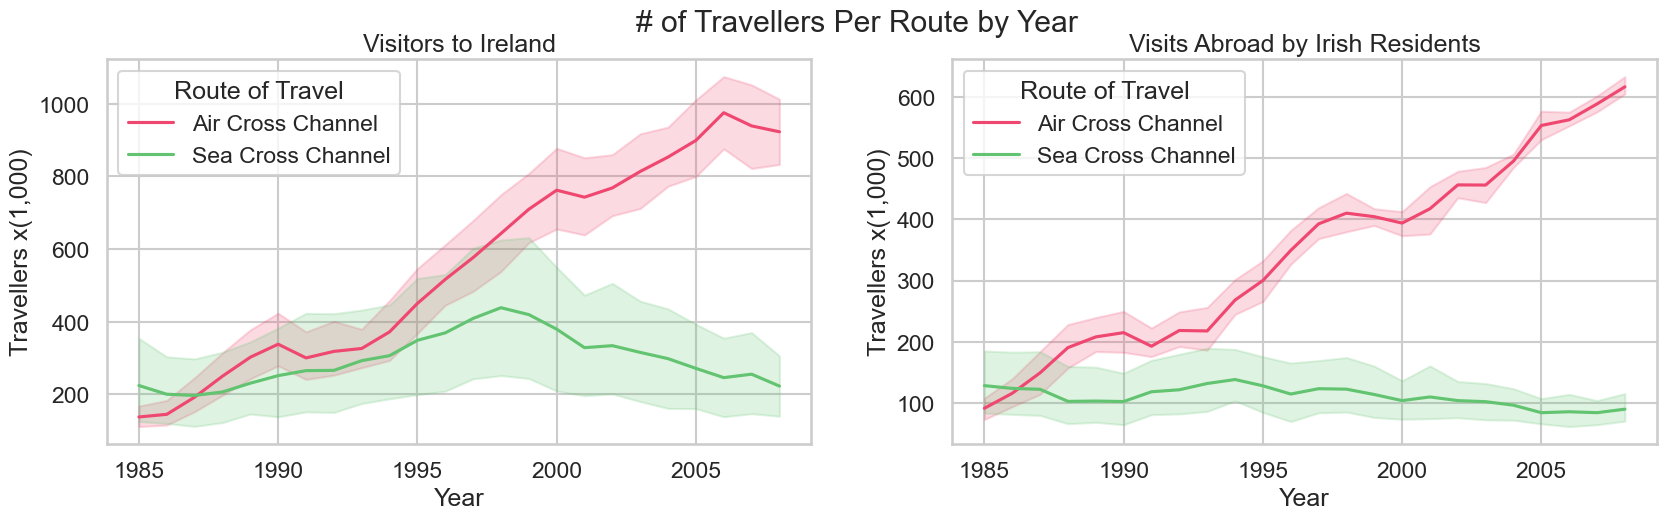

In [76]:
# Declare variable for easier access to direction of travel
VISITORS_TO_IRELAND = 'Visitors to Ireland'
VISITORS_FROM_IRELAND = 'Visits Abroad by Irish Residents'

FILTER_CROSS_CHANNEL = ((route_quarter_tourism['Route of Travel'] == 'Air Cross Channel') | (route_quarter_tourism['Route of Travel'] == 'Sea Cross Channel'))

to_ireland_df = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL & (route_quarter_tourism['Direction'] ==  VISITORS_TO_IRELAND)]
from_ireland_df = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL & (route_quarter_tourism['Direction'] ==  VISITORS_FROM_IRELAND)]

### Start of Data Visualization
fig, axes = plt.subplots(1, 2, figsize=(20, 5))

#plt.xticks(rotation=45)
sns.lineplot(x="Year", y="Travellers x(1,000)", hue="Route of Travel", data=to_ireland_df, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND);

sns.lineplot(x="Year", y="Travellers x(1,000)", hue="Route of Travel", data=from_ireland_df, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND);
                  
fig.suptitle('# of Travellers Per Route by Year');


### Defining a function to determine frequency distribution of each route of cross channel travel for incoming and outgoing travel

In [77]:
# Calculate the sum for all Routes of Travel per **year - quarter - direction**
def calculate_frequencies(df):
    print(df.shape)

    sums = df.groupby(['Year', 'Quarter', 'Direction'], as_index=False).sum()
    sums.rename(columns={"Travellers x(1,000)": "Total Num"}, inplace=True)

    # Calculate the number of unique routes, because this is how many times we need to repeat each sum for the division operation
    repeats = df['Route of Travel'].nunique()
    # Extract the total numbers per **year - quarter - direction** and repeat them 3 times, because we have 3 routes
    mask = sums.loc[sums.index.repeat(repeats)].reset_index(drop=True)['Total Num']
    print(mask.shape) # I am making sure the shape of the mask matches the shape of the dataframe we will apply this to

    mask.head()

    # We have to prodive 'ignore_index=True', because otherwise the division by the totals_mask will produce NaN values, as indexes are misaligned
    df.sort_values(by=['Year', 'Quarter', 'Direction', 'Route of Travel'], inplace=True, ignore_index=True)

    #concatenated_route_quarter_tourism['Distribution']
    df['Distribution Per Route'] = df['Travellers x(1,000)'] / mask
    return df

(384, 5)
(384,)


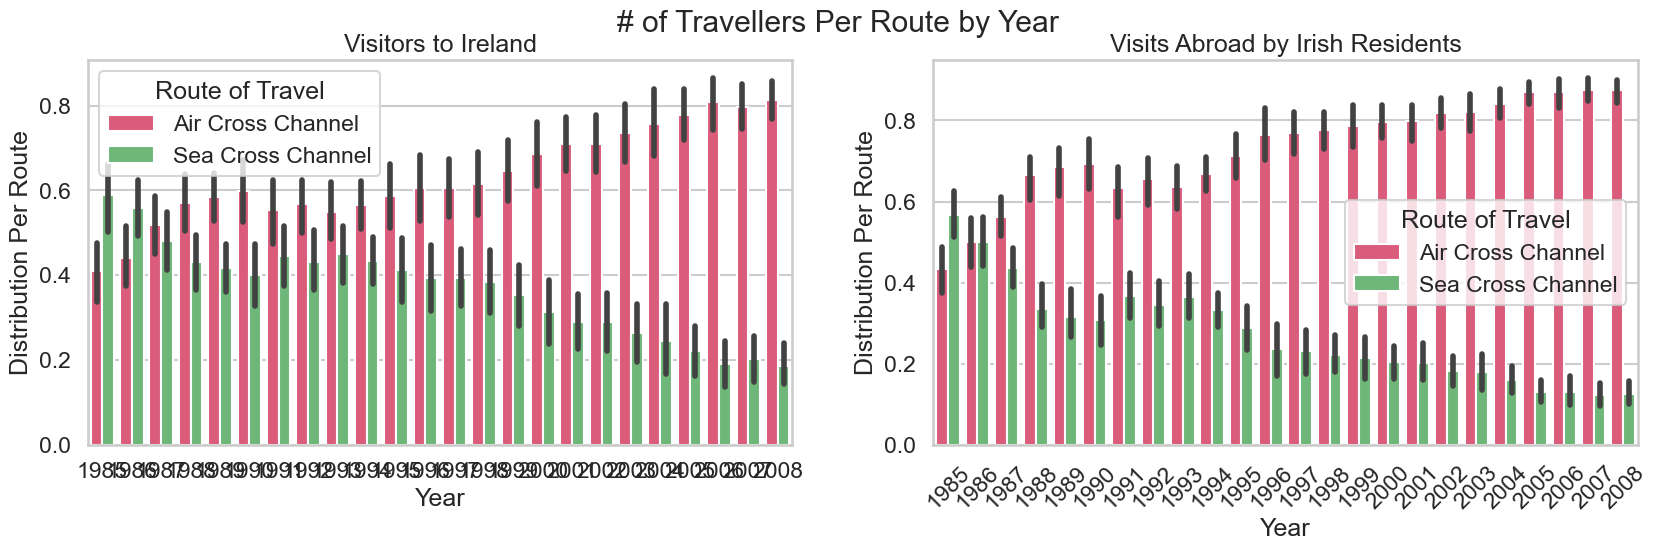

In [99]:
x_channel = route_quarter_tourism.loc[FILTER_CROSS_CHANNEL]
freqs = calculate_frequencies(x_channel)
freqs['year quarter'] = freqs['Year'].astype(str) + 'Q' + freqs['Quarter'].astype(str)
freqs

to_ireland_df = freqs.loc[(freqs['Direction'] ==  VISITORS_TO_IRELAND)]
from_ireland_df = freqs.loc[(freqs['Direction'] ==  VISITORS_FROM_IRELAND)]

fig, axes = plt.subplots(1, 2, figsize=(20, 5))

sns.barplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=to_ireland_df, ax=axes[0])
axes[0].set_title(VISITORS_TO_IRELAND);

sns.barplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=from_ireland_df, ax=axes[1])
axes[1].set_title(VISITORS_FROM_IRELAND);
plt.xticks(rotation=45)

fig.suptitle('# of Travellers Per Route by Year');

In [79]:
# import seaborn as sns
# import matplotlib.pyplot as plt

# plt.figure(figsize=(12, 6))
# ax = sns.lineplot(x="Year", y="Distribution Per Route", hue="Route of Travel", data=freqs)
# plt.xticks(rotation=45)
# ax.set_title('Distribution Per Route by Year')
# plt.show(); # Put semicolon as per https://stackoverflow.com/questions/51030011/maplotlib-gives-the-list-of-array-outputs-before-showing-the-scatter-plot-in-pyt as otherise it will show the array of the output before the

### Assessing change in distribution of route of travel cross channel per Quarter over time

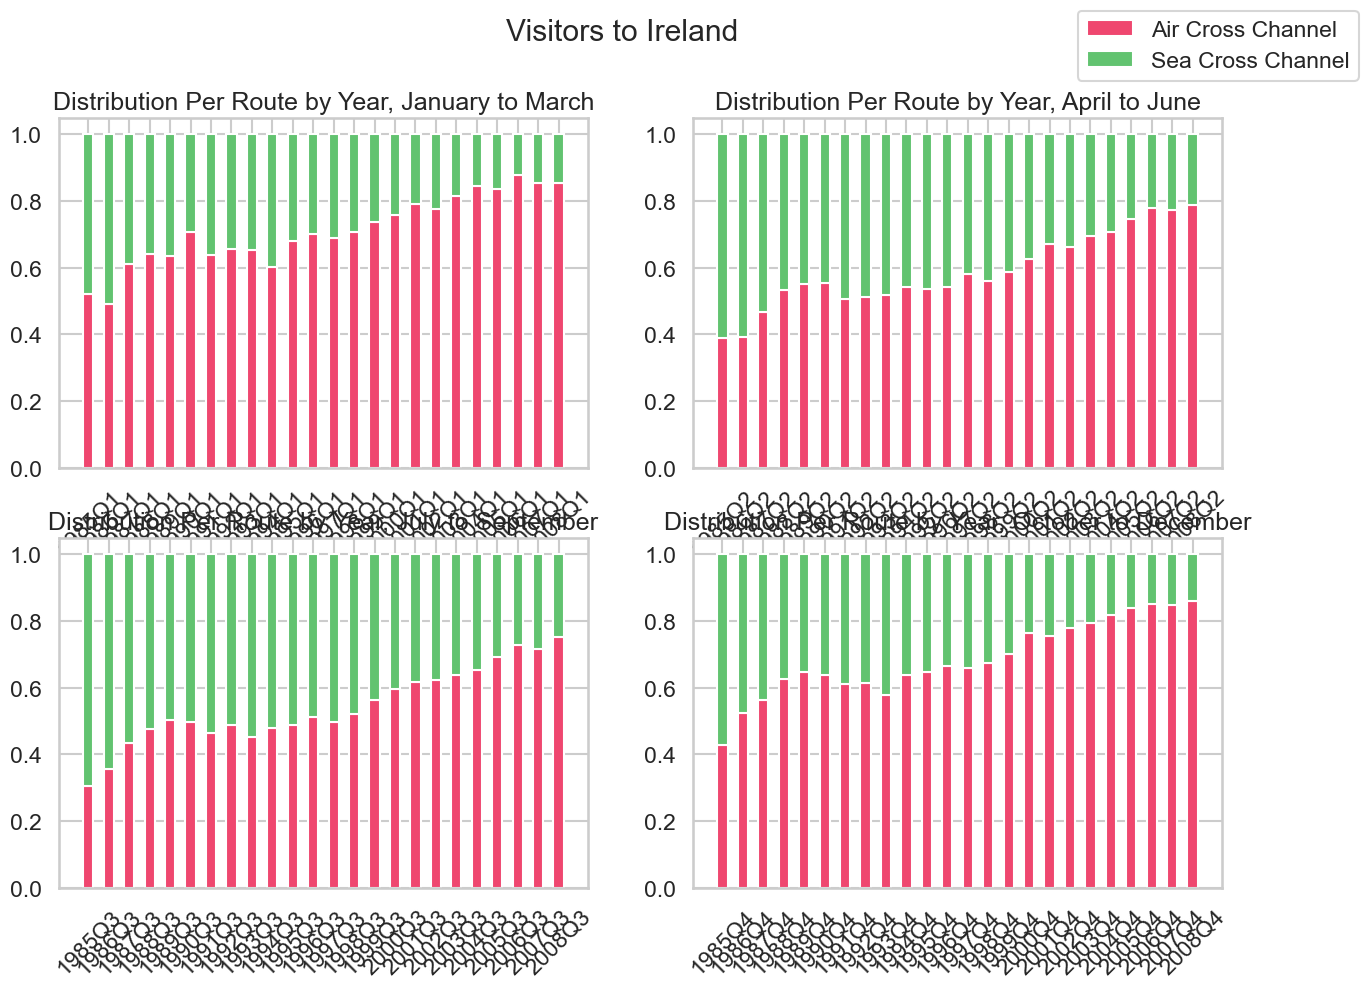

In [102]:
def plot_by_quarter(df, title):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    q1 = df.loc[(df['Quarter'] == 1)]
    air1 = q1.loc[q1['Route of Travel'] == 'Air Cross Channel']
    _ = axes[0, 0].bar(air1['year quarter'], air1['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea1 = q1.loc[q1['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[0, 0].bar(sea1['year quarter'], sea1['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air1['Distribution Per Route'].to_numpy())

    q2 = df.loc[(df['Quarter'] == 2)]
    air2 = q2.loc[q2['Route of Travel'] == 'Air Cross Channel']
    _ = axes[0, 1].bar(air2['year quarter'], air2['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea2 = q2.loc[q2['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[0, 1].bar(sea2['year quarter'], sea2['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air2['Distribution Per Route'].to_numpy())

    q3 = df.loc[(df['Quarter'] == 3)]
    air3 = q3.loc[q3['Route of Travel'] == 'Air Cross Channel']
    _ = axes[1, 0].bar(air3['year quarter'], air3['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea3 = q3.loc[q3['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[1, 0].bar(sea3['year quarter'], sea3['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air3['Distribution Per Route'].to_numpy())

    q4 = df.loc[(df['Quarter'] == 4)]
    air4 = q4.loc[q4['Route of Travel'] == 'Air Cross Channel']
    _ = axes[1, 1].bar(air4['year quarter'], air4['Distribution Per Route'], 0.5, label='Air Cross Channel', bottom=0)
    sea4 = q4.loc[q4['Route of Travel'] == 'Sea Cross Channel']
    _ = axes[1, 1].bar(sea4['year quarter'], sea4['Distribution Per Route'], 0.5, label='Sea Cross Channel', bottom=air4['Distribution Per Route'].to_numpy())

    axes[0, 0].xaxis.set_tick_params(rotation=45)
    axes[0, 0].set_title('Distribution Per Route by Year, January to March')

    axes[0, 1].xaxis.set_tick_params(rotation=45)
    axes[0, 1].set_title('Distribution Per Route by Year, April to June')

    axes[1, 0].xaxis.set_tick_params(rotation=45)
    axes[1, 0].set_title('Distribution Per Route by Year, July to September')

    axes[1, 1].xaxis.set_tick_params(rotation=45)
    axes[1, 1].set_title('Distribution Per Route by Year, October to December')

    # Taken from https://stackoverflow.com/questions/9834452/how-do-i-make-a-single-legend-for-many-subplots
    h, l = axes[0, 0].get_legend_handles_labels()
    fig.legend(h, l, loc='upper right')
    fig.suptitle(title);
    plt.show();

plot_by_quarter(to_ireland_df, VISITORS_TO_IRELAND)


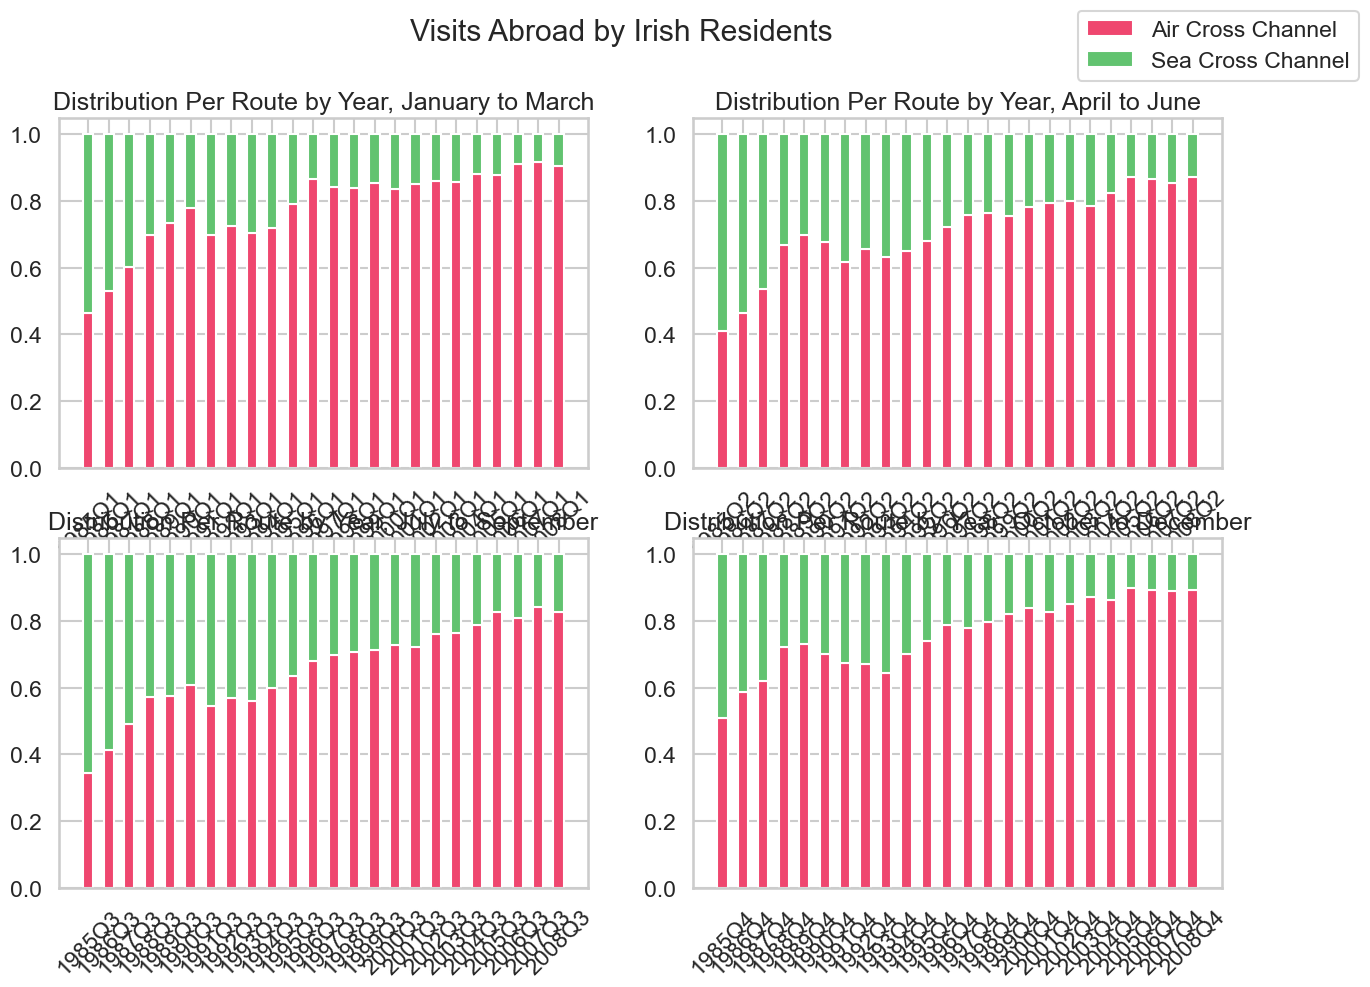

In [103]:
plot_by_quarter(from_ireland_df, VISITORS_FROM_IRELAND)


### Merge Air and Sea Cross channel values into combined Cross Channel values

In [108]:
def merge_air_and_sea(df, common_cols):
    # Select cross channel travel by both sea and air for each quarter and year from the dataset
    cross_channel_df = df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True]
    #pd.set_option('display.max_rows', cross_channel_df.shape[0]+1)
    cross_channel_df.shape
    
    # Combine Air and Sea cross channel travel into Cross channel travel dataframe
    combined_cross_channel = cross_channel_df.groupby(common_cols, as_index=False).sum()
    combined_cross_channel['Route of Travel'] = 'Cross Channel'
    combined_cross_channel.shape

    # Remove Air and Sea Cross Channel travel from original dataset
    df = df.drop(df[df.isin(['Air Cross Channel', 'Sea Cross Channel'])['Route of Travel']==True].index)
    # Concatenate original dataset with new Cross Channel travel dataset
    df = pd.concat([df, combined_cross_channel], axis=0, ignore_index=True)
    #pd.set_option('display.max_rows', df.shape[0]+1)
    # df
    # Change order of routes to "All Routes", "Cross Channel", "Continental Europe", and "Transatlantic" to be consistent with the original dataset.
    concatenated_df = pd.concat([df[df['Route of Travel'] == 'All Routes'],
                                df[df['Route of Travel'] == 'Cross Channel'],
                                df[df['Route of Travel'] == 'Continental Europe'],
                                df[df['Route of Travel'] == 'Transatlantic']])

    # Reset the index of the concatenated dataframe
    concatenated_df.reset_index(drop=True, inplace=True)
    return concatenated_df

In [109]:
concatenated_route_quarter_tourism = merge_air_and_sea(route_quarter_tourism, ['Year', 'Quarter', 'Direction'])
concatenated_route_quarter_tourism['Route of Travel'].value_counts()

Route of Travel
All Routes            192
Cross Channel         192
Continental Europe    192
Transatlantic         192
Name: count, dtype: int64

### Removing All routes values for Route of Travel

In [129]:
concatenated_route_quarter_tourism = concatenated_route_quarter_tourism.drop(concatenated_route_quarter_tourism[concatenated_route_quarter_tourism.isin(['All Routes'])['Route of Travel']==True].index)
# Calculate the distribution of travellers per route
concatenated_route_quarter_tourism = calculate_frequencies(concatenated_route_quarter_tourism)
concatenated_route_quarter_tourism


(576, 6)
(576,)


,Route of Travel,Year,Quarter,Direction,"Travellers x(1,000)",Distribution Per Route
0,Continental Europe,1985,1,Visitors to Ireland,28,0.110236
1,Cross Channel,1985,1,Visitors to Ireland,211,0.830709
2,Transatlantic,1985,1,Visitors to Ireland,15,0.059055
3,Continental Europe,1985,1,Visits Abroad by Irish Residents,41,0.220430
4,Cross Channel,1985,1,Visits Abroad by Irish Residents,140,0.752688
...,...,...,...,...,...,...
571,Cross Channel,2008,4,Visitors to Ireland,981,0.589189
572,Transatlantic,2008,4,Visitors to Ireland,101,0.060661
573,Continental Europe,2008,4,Visits Abroad by Irish Residents,806,0.492966
574,Cross Channel,2008,4,Visits Abroad by Irish Residents,677,0.414067


## Assessing Distribution of travellers to Ireland by different routes of travel over time

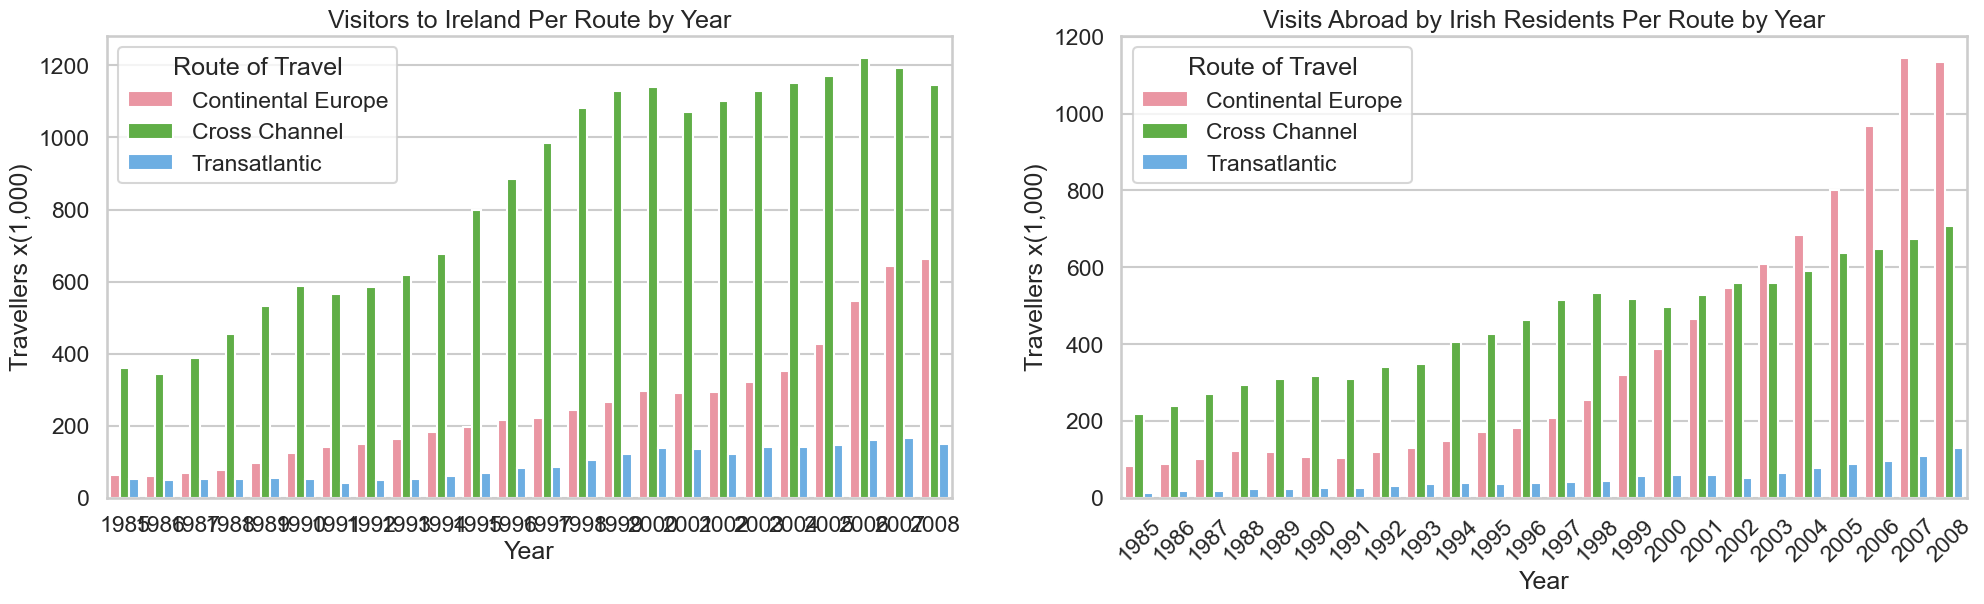

In [132]:
to_ireland_df = concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Direction'] == VISITORS_TO_IRELAND]
from_ireland_df = concatenated_route_quarter_tourism[concatenated_route_quarter_tourism['Direction'] == VISITORS_FROM_IRELAND]

fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.barplot(x='Year', y='Travellers x(1,000)', data=to_ireland_df, hue='Route of Travel', ci=None, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND + ' Per Route by Year');

sns.barplot(x='Year', y='Travellers x(1,000)', data=from_ireland_df, hue='Route of Travel', ci=None, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND + ' Per Route by Year');
plt.xticks(rotation=45);


### Assessing Distribution of travellers from Ireland per route over time

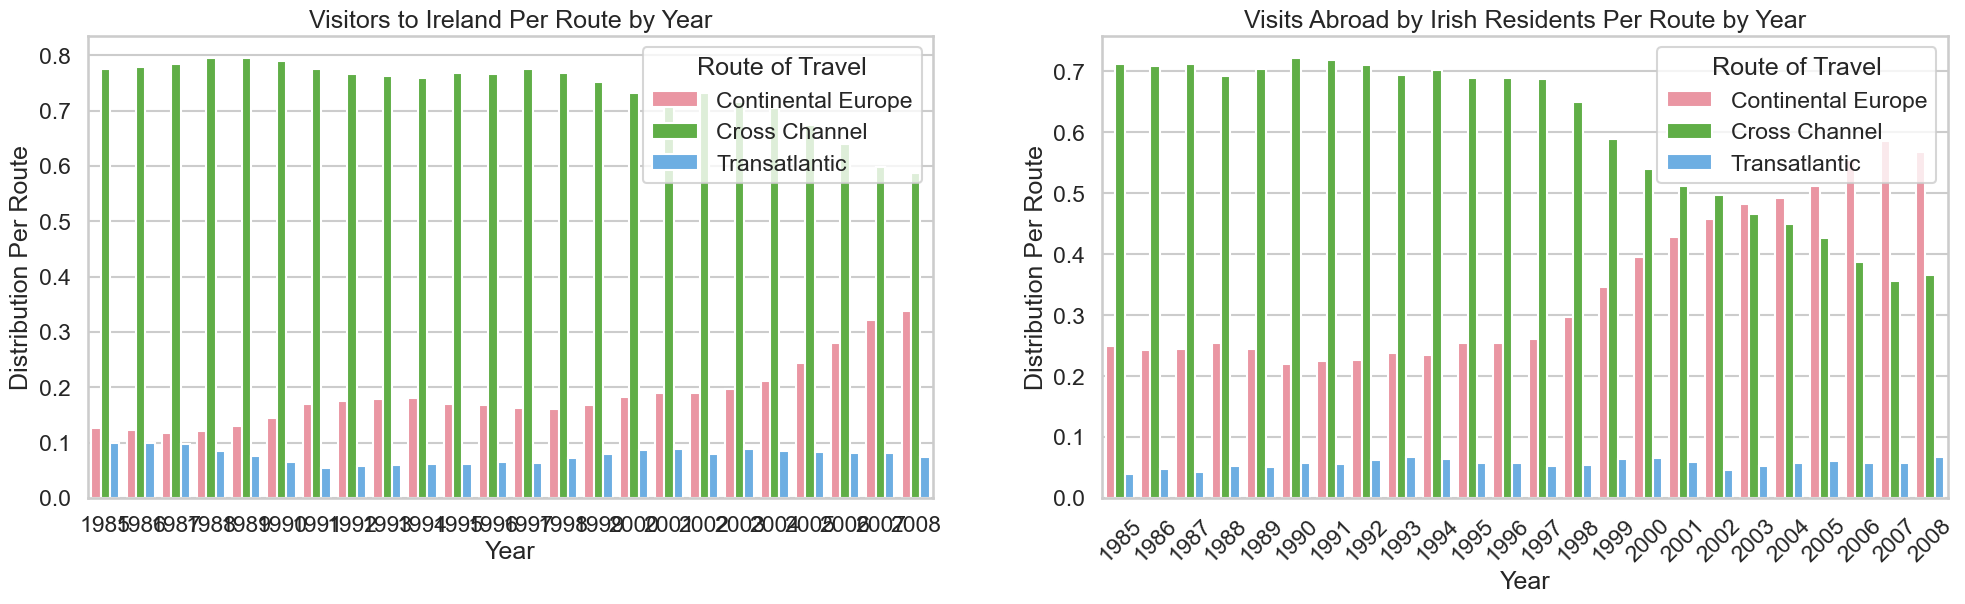

In [133]:
fig, axes = plt.subplots(1, 2, figsize=(24, 6))

sns.barplot(x='Year', y='Distribution Per Route', data=to_ireland_df, hue='Route of Travel', ci=None, ax=axes[0]);
axes[0].set_title(VISITORS_TO_IRELAND + ' Per Route by Year');

sns.barplot(x='Year', y='Distribution Per Route', data=from_ireland_df, hue='Route of Travel', ci=None, ax=axes[1]);
axes[1].set_title(VISITORS_FROM_IRELAND + ' Per Route by Year');
plt.xticks(rotation=45);

In [64]:
#Now we are counting number of days which are sunny within 50 days
# df_2008 = to_ireland_df.loc[(to_ireland_df['Year'] == 2008)]

# value_counts1 = df_2008['Travellers x(1,000)'].value_counts()
# relative_frequencies1 = value_counts1/len(dataset)
# relative_frequencies1

NameError: name 'dataset' is not defined

## Dataset 2_reason - Exploration and Cleaning
#### Explore reason dataset
#### Dataset describes travel to and from Ireland by all routes between the years of 1976 and 2008, yearly, with lenght of stay, reason for travel and expenditure .

In [35]:
# Read csv file into pandas dataframe 
# url = https://data.gov.ie/dataset/tma05-visits-to-and-from-ireland/resource/3fe9ec9d-c16f-47dc-92e3-6749c6361d7c

reason_df = pd.read_csv("TMA05-Visits-to-and-from-Ireland.csv")
reason_df.shape
reason_df.head(20)

(792, 8)

,C02118V02559,Reason for Journey,TLIST(A1),Year,STATISTIC,Statistic Label,UNIT,VALUE
0,1,Holiday/leisure/recreation,1976,1976,TMA05C1,Expenditure by Vistors to Ireland,Euro Million,69.0
1,1,Holiday/leisure/recreation,1976,1976,TMA05C2,Visitors to Ireland,Thousand,553.0
2,1,Holiday/leisure/recreation,1976,1976,TMA05C3,Average Length of Stay by Visitors to Ireland,Nights,NaN
3,1,Holiday/leisure/recreation,1976,1976,TMA05C4,Expenditure by Irish Residents Abroad,Euro Million,81.0
4,1,Holiday/leisure/recreation,1976,1976,TMA05C5,Visits Abroad by Irish Residents,Thousand,428.0
5,1,Holiday/leisure/recreation,1976,1976,TMA05C6,Average Length of Stay Abroad by Irish Residents,Nights,NaN
6,1,Holiday/leisure/recreation,1977,1977,TMA05C1,Expenditure by Vistors to Ireland,Euro Million,98.0
7,1,Holiday/leisure/recreation,1977,1977,TMA05C2,Visitors to Ireland,Thousand,665.0
8,1,Holiday/leisure/recreation,1977,1977,TMA05C3,Average Length of Stay by Visitors to Ireland,Nights,NaN
9,1,Holiday/leisure/recreation,1977,1977,TMA05C4,Expenditure by Irish Residents Abroad,Euro Million,94.0


In [36]:
reason_df.drop(columns=['C02118V02559', 'TLIST(A1)', 'STATISTIC'], inplace=True)
reason_df.rename(columns={"Statistic Label": "Direction"}, inplace=True)

In [37]:
reason_df['Reason for Journey'].value_counts()
reason_df['Direction'].value_counts()
reason_df['UNIT'].value_counts()
reason_df['VALUE'].isna().sum() # Less than 10% of the data is missing

Reason for Journey
Holiday/leisure/recreation    198
Visit to friends/relatives    198
Business                      198
Other reason for journey      198
Name: count, dtype: int64

Direction
Expenditure by Vistors to Ireland                   132
Visitors to Ireland                                 132
Average Length of Stay by Visitors to Ireland       132
Expenditure by Irish Residents Abroad               132
Visits Abroad by Irish Residents                    132
Average Length of Stay Abroad by Irish Residents    132
Name: count, dtype: int64

UNIT
Euro Million    264
Thousand        264
Nights          264
Name: count, dtype: int64

56

In [38]:
# Extract expenditure data
expenditure_df = reason_df.loc[(reason_df['Direction'] == 'Expenditure by Vistors to Ireland') | (reason_df['Direction'] == 'Expenditure by Irish Residents Abroad')].reset_index(drop=True)

# Extract number of travellers data
travellors_df = reason_df.loc[(reason_df['Direction'] == 'Visitors to Ireland') | (reason_df['Direction'] == 'Visits Abroad by Irish Residents')].reset_index(drop=True)

# Extract average length of stay data
duration_df = reason_df.loc[(reason_df['Direction'] == 'Average Length of Stay by Visitors to Ireland') | (reason_df['Direction'] == 'Average Length of Stay Abroad by Irish Residents')].reset_index(drop=True)

expenditure_df.shape
travellors_df.shape
duration_df.shape

(264, 5)

(264, 5)

(264, 5)

In [39]:
# Renaming column values to enable concatenation of the two datasets
direction_mapping = {'Expenditure by Vistors to Ireland': 'Visitors to Ireland',
                     'Expenditure by Irish Residents Abroad': 'Visits Abroad by Irish Residents',
                     'Average Length of Stay by Visitors to Ireland': 'Visitors to Ireland',
                     'Average Length of Stay Abroad by Irish Residents': 'Visits Abroad by Irish Residents'}

expenditure_df["Direction"]=expenditure_df['Direction'].apply(lambda x: direction_mapping[x])
duration_df["Direction"]=duration_df['Direction'].apply(lambda x: direction_mapping[x])

In [40]:
expenditure_df.rename(columns={"VALUE": "Expenditure (x € Mil)"}, inplace=True)
expenditure_df.drop(columns=['UNIT'], inplace=True)

travellors_df.rename(columns={"VALUE": "Travellers (x 1,000)"}, inplace=True)
travellors_df.drop(columns=['UNIT'], inplace=True)

duration_df.rename(columns={"VALUE": "Avg Length of Stay (x Nights)"}, inplace=True)
duration_df.drop(columns=['UNIT'], inplace=True)

In [41]:
expenditure_df.head()
travellors_df.head()
duration_df.head()

,Reason for Journey,Year,Direction,Expenditure (x € Mil)
0,Holiday/leisure/recreation,1976,Visitors to Ireland,69.0
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,81.0
2,Holiday/leisure/recreation,1977,Visitors to Ireland,98.0
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,94.0
4,Holiday/leisure/recreation,1978,Visitors to Ireland,132.0


,Reason for Journey,Year,Direction,"Travellers (x 1,000)"
0,Holiday/leisure/recreation,1976,Visitors to Ireland,553.0
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,428.0
2,Holiday/leisure/recreation,1977,Visitors to Ireland,665.0
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,420.0
4,Holiday/leisure/recreation,1978,Visitors to Ireland,838.0


,Reason for Journey,Year,Direction,Avg Length of Stay (x Nights)
0,Holiday/leisure/recreation,1976,Visitors to Ireland,NaN
1,Holiday/leisure/recreation,1976,Visits Abroad by Irish Residents,NaN
2,Holiday/leisure/recreation,1977,Visitors to Ireland,NaN
3,Holiday/leisure/recreation,1977,Visits Abroad by Irish Residents,NaN
4,Holiday/leisure/recreation,1978,Visitors to Ireland,NaN


In [42]:
final_df = travellors_df.merge(expenditure_df, on=['Year', 'Direction', 'Reason for Journey'], how='outer')
final_df = final_df.merge(duration_df, on=['Year', 'Direction', 'Reason for Journey'], how='outer')
final_df = final_df.reindex(columns=['Year', 'Direction', 'Reason for Journey', 'Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)'])
pd.set_option('display.max_rows', final_df.shape[0]+1)
final_df.head(55)

,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
0,1976,Visitors to Ireland,Business,188.0,15.0,NaN
1,1976,Visitors to Ireland,Holiday/leisure/recreation,553.0,69.0,NaN
2,1976,Visitors to Ireland,Other reason for journey,75.0,4.0,NaN
3,1976,Visitors to Ireland,Visit to friends/relatives,494.0,43.0,NaN
4,1976,Visits Abroad by Irish Residents,Business,150.0,33.0,NaN
5,1976,Visits Abroad by Irish Residents,Holiday/leisure/recreation,428.0,81.0,NaN
6,1976,Visits Abroad by Irish Residents,Other reason for journey,87.0,10.0,NaN
7,1976,Visits Abroad by Irish Residents,Visit to friends/relatives,222.0,32.0,NaN
8,1977,Visitors to Ireland,Business,214.0,20.0,NaN
9,1977,Visitors to Ireland,Holiday/leisure/recreation,665.0,98.0,NaN


In [43]:
final_df.describe()

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
count,264.00000,264.000000,264.000000,208.000000
mean,1992.00000,851.609848,462.117424,9.217308
std,9.53999,891.930948,666.849238,3.092720
min,1976.00000,75.000000,4.000000,3.400000
25%,1984.00000,312.000000,99.500000,6.900000
50%,1992.00000,559.500000,252.000000,9.250000
75%,2000.00000,976.250000,521.750000,11.000000
max,2008.00000,4824.000000,4975.000000,23.000000


In [44]:
final_df.dtypes



Year                               int64
Direction                         object
Reason for Journey                object
Travellers (x 1,000)             float64
Expenditure (x € Mil)            float64
Avg Length of Stay (x Nights)    float64
dtype: object

## Displaying Distribution of Features of Visitors too and from Ireland per year

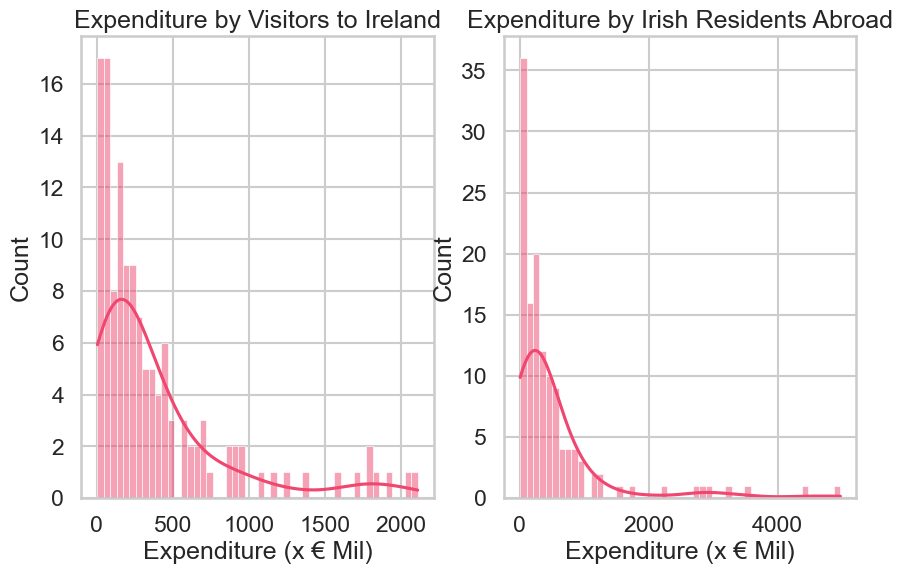

In [45]:
# Assessing distribution of Expenditure by visitors to Ireland and visits abroad by Irish residents 
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Expenditure (x € Mil)', ax=axes[0], kde=True, bins=50);
sns.histplot(data=set2, x='Expenditure (x € Mil)', ax=axes[1], kde=True, bins=50);
axes[0].set_title('Expenditure by Visitors to Ireland');
axes[1].set_title('Expenditure by Irish Residents Abroad');


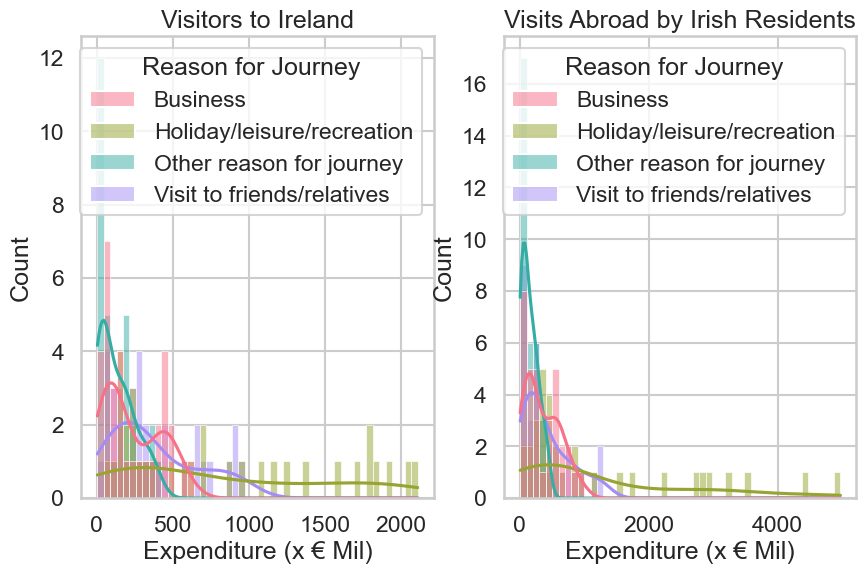

In [46]:
# Assessing distribution of Expenditure by visitors to Ireland and visits abroad by Irish residents by reason for journey

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Expenditure (x € Mil)', ax=axes[0], kde=True, bins=50, hue='Reason for Journey');
sns.histplot(data=set2, x='Expenditure (x € Mil)', ax=axes[1], kde=True, bins=50, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');

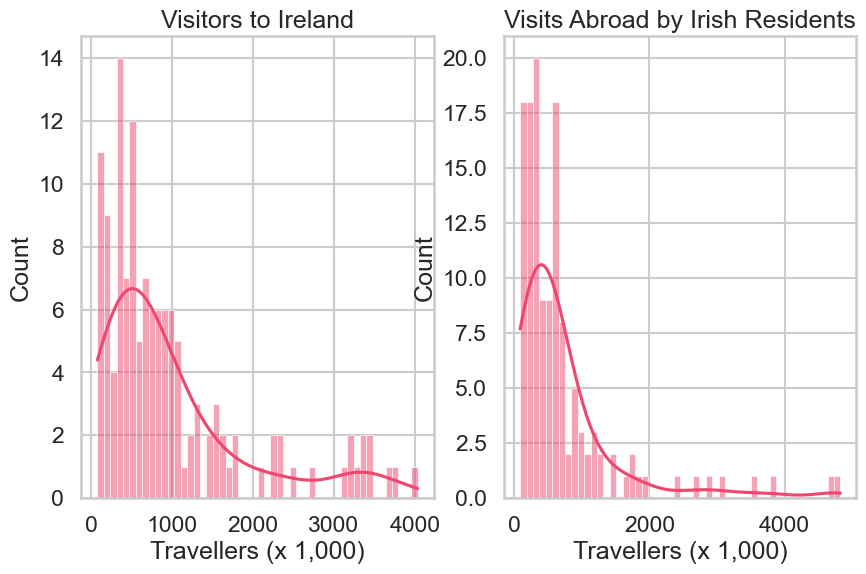

In [47]:
# Assessing distribution of number of travellers to Ireland and visits abroad by Irish residents 
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Travellers (x 1,000)', ax=axes[0], kde=True, bins=50);
sns.histplot(data=set2, x='Travellers (x 1,000)', ax=axes[1], kde=True, bins=50);
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


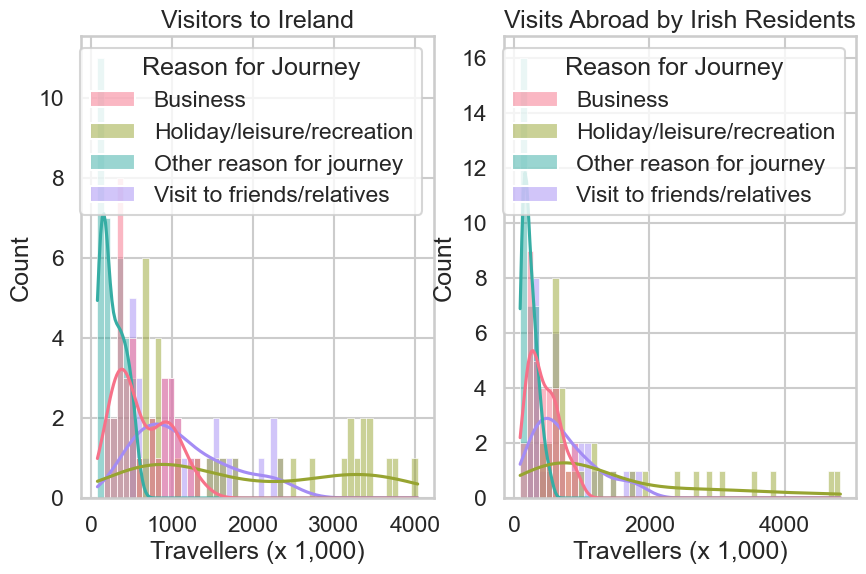

In [48]:
# Assessing distribution of number of travellers to Ireland and visits abroad by Irish residents by reason for journey

fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Travellers (x 1,000)', ax=axes[0], kde=True, bins=50, hue='Reason for Journey');
sns.histplot(data=set2, x='Travellers (x 1,000)', ax=axes[1], kde=True, bins=50, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');

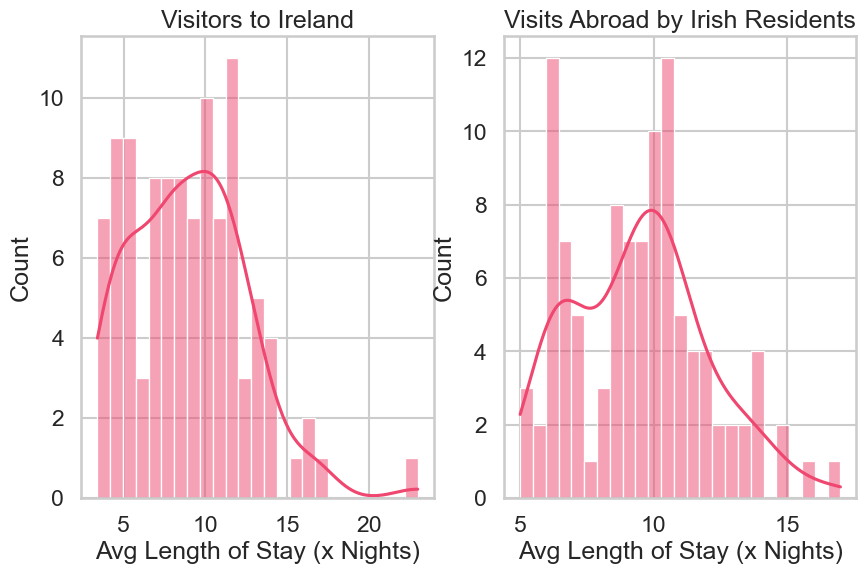

In [49]:
# Assessing distribution of length of stay of visitors to Ireland and visits abroad by Irish residents 
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Avg Length of Stay (x Nights)', ax=axes[0], kde=True, bins=25);
sns.histplot(data=set2, x='Avg Length of Stay (x Nights)', ax=axes[1], kde=True, bins=25);
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


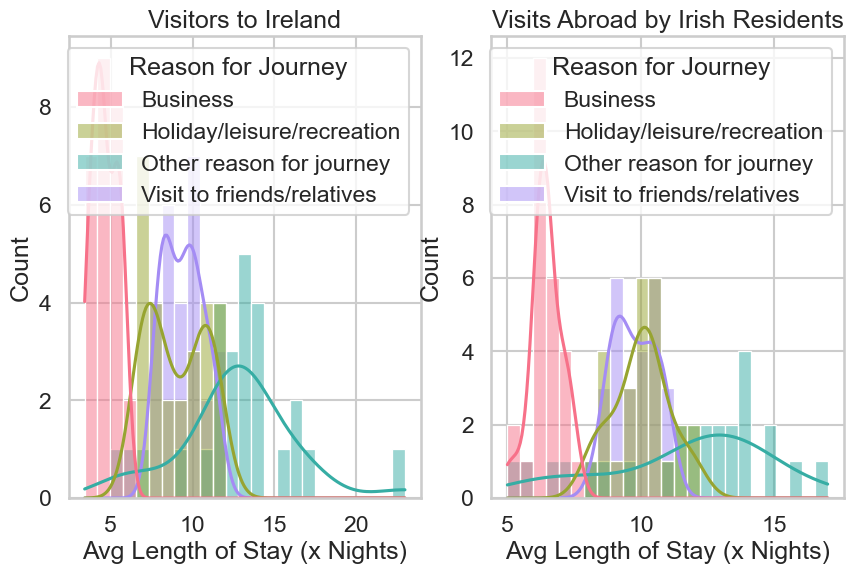

In [50]:
# Assessing distribution of lenght of stay of visitors to Ireland and visits abroad by Irish residents by reason for journey
fig, axes = plt.subplots(1, 2, figsize=(10, 6))

set1 = final_df.loc[final_df['Direction'] == 'Visitors to Ireland']
set2 = final_df.loc[final_df['Direction'] == 'Visits Abroad by Irish Residents']
sns.histplot(data=set1, x='Avg Length of Stay (x Nights)', ax=axes[0], kde=True, bins=25, hue='Reason for Journey');
sns.histplot(data=set2, x='Avg Length of Stay (x Nights)', ax=axes[1], kde=True, bins=25, hue='Reason for Journey');
axes[0].set_title('Visitors to Ireland');
axes[1].set_title('Visits Abroad by Irish Residents');


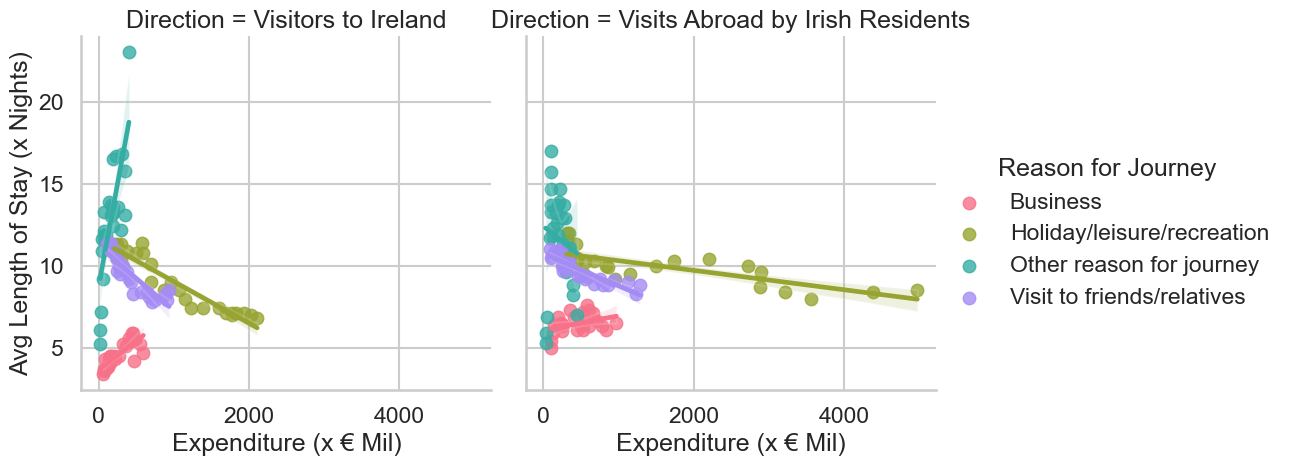

In [51]:
# Assesing the relationship between variables (the average length of stay and expenditure) for visitors to Ireland and visits abroad by Irish residents by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Expenditure (x € Mil)", y="Avg Length of Stay (x Nights)",
    height=5, hue="Reason for Journey", col="Direction"
)

# Use more informative axis labels than are provided by default
g.set_axis_labels("Expenditure (x € Mil)", "Avg Length of Stay (x Nights)");

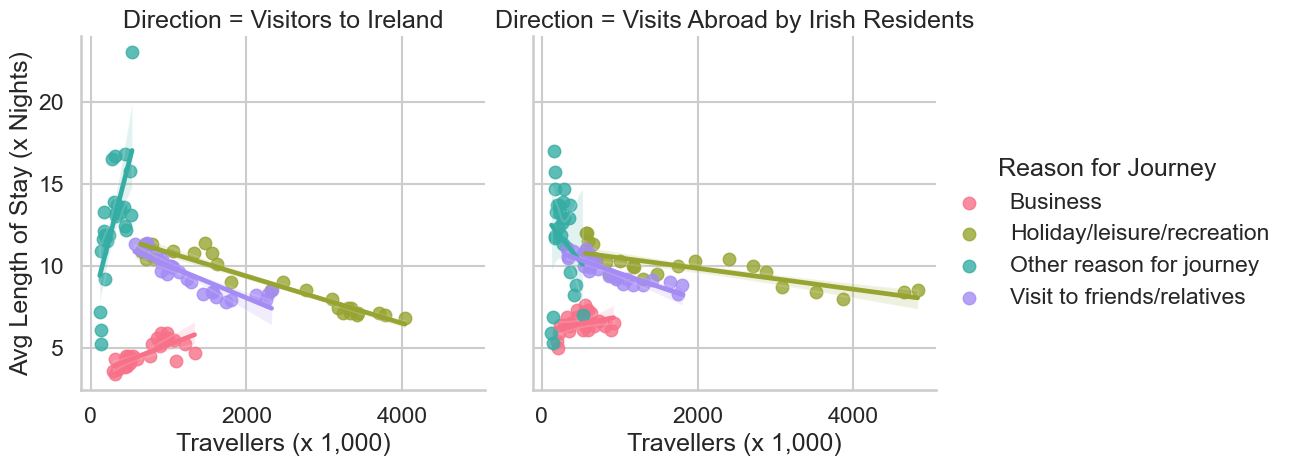

In [52]:
# Assesing the relationship between variables (the average length of stay and number of travellers) for visitors to Ireland and visits abroad by Irish residents by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Travellers (x 1,000)", y="Avg Length of Stay (x Nights)",
    height=5, col="Direction", hue="Reason for Journey"
)

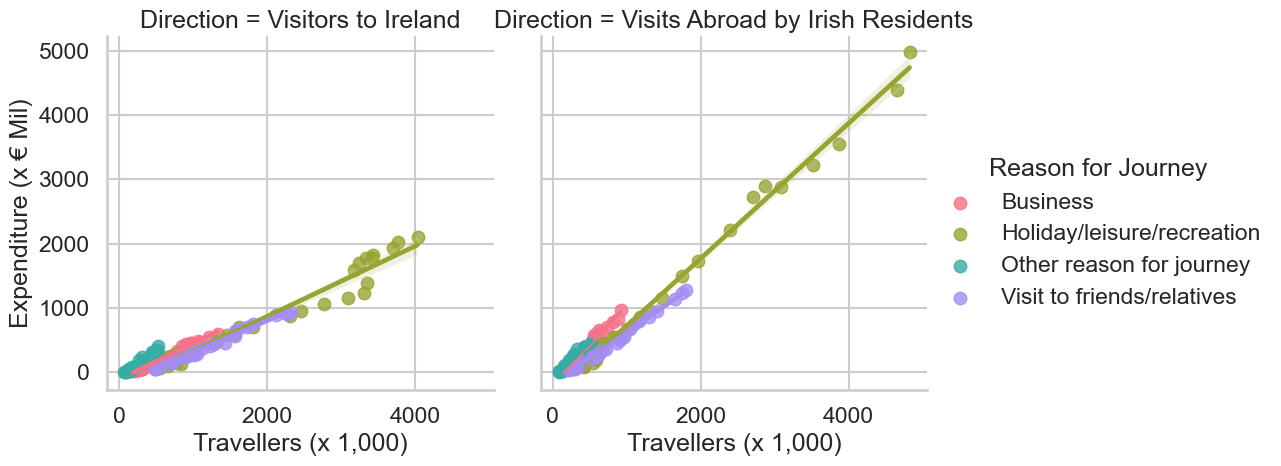

In [53]:
# Assesing the relationship between variables (expenditure and number of travellers) for visitors to Ireland and visits abroad by Irish residents by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Travellers (x 1,000)", y="Expenditure (x € Mil)",
    height=5, col="Direction", hue="Reason for Journey")

### The variables Expenditure and number of travellers are the only variables which demonstrate a positive correlation

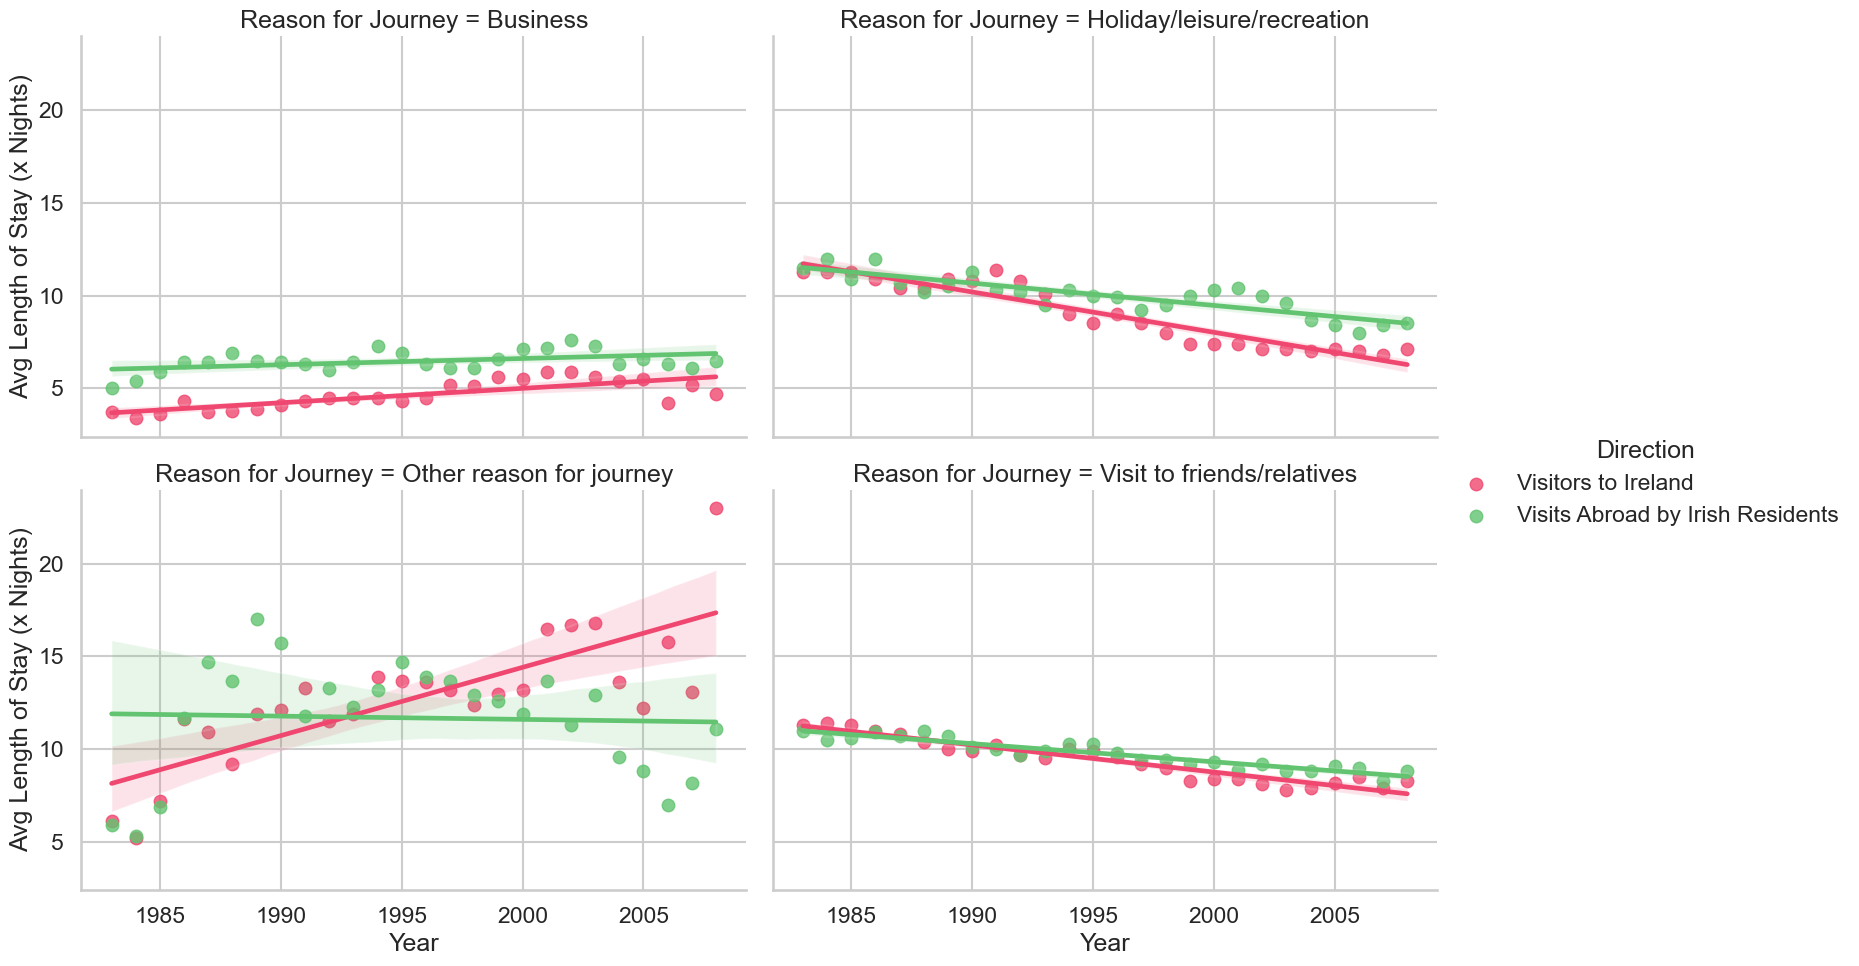

In [54]:
# Assess the annual trend of the average length of stay over the years by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Year", y="Avg Length of Stay (x Nights)",
    height=5, hue= "Direction", col="Reason for Journey", col_wrap=2, aspect=1.5
)

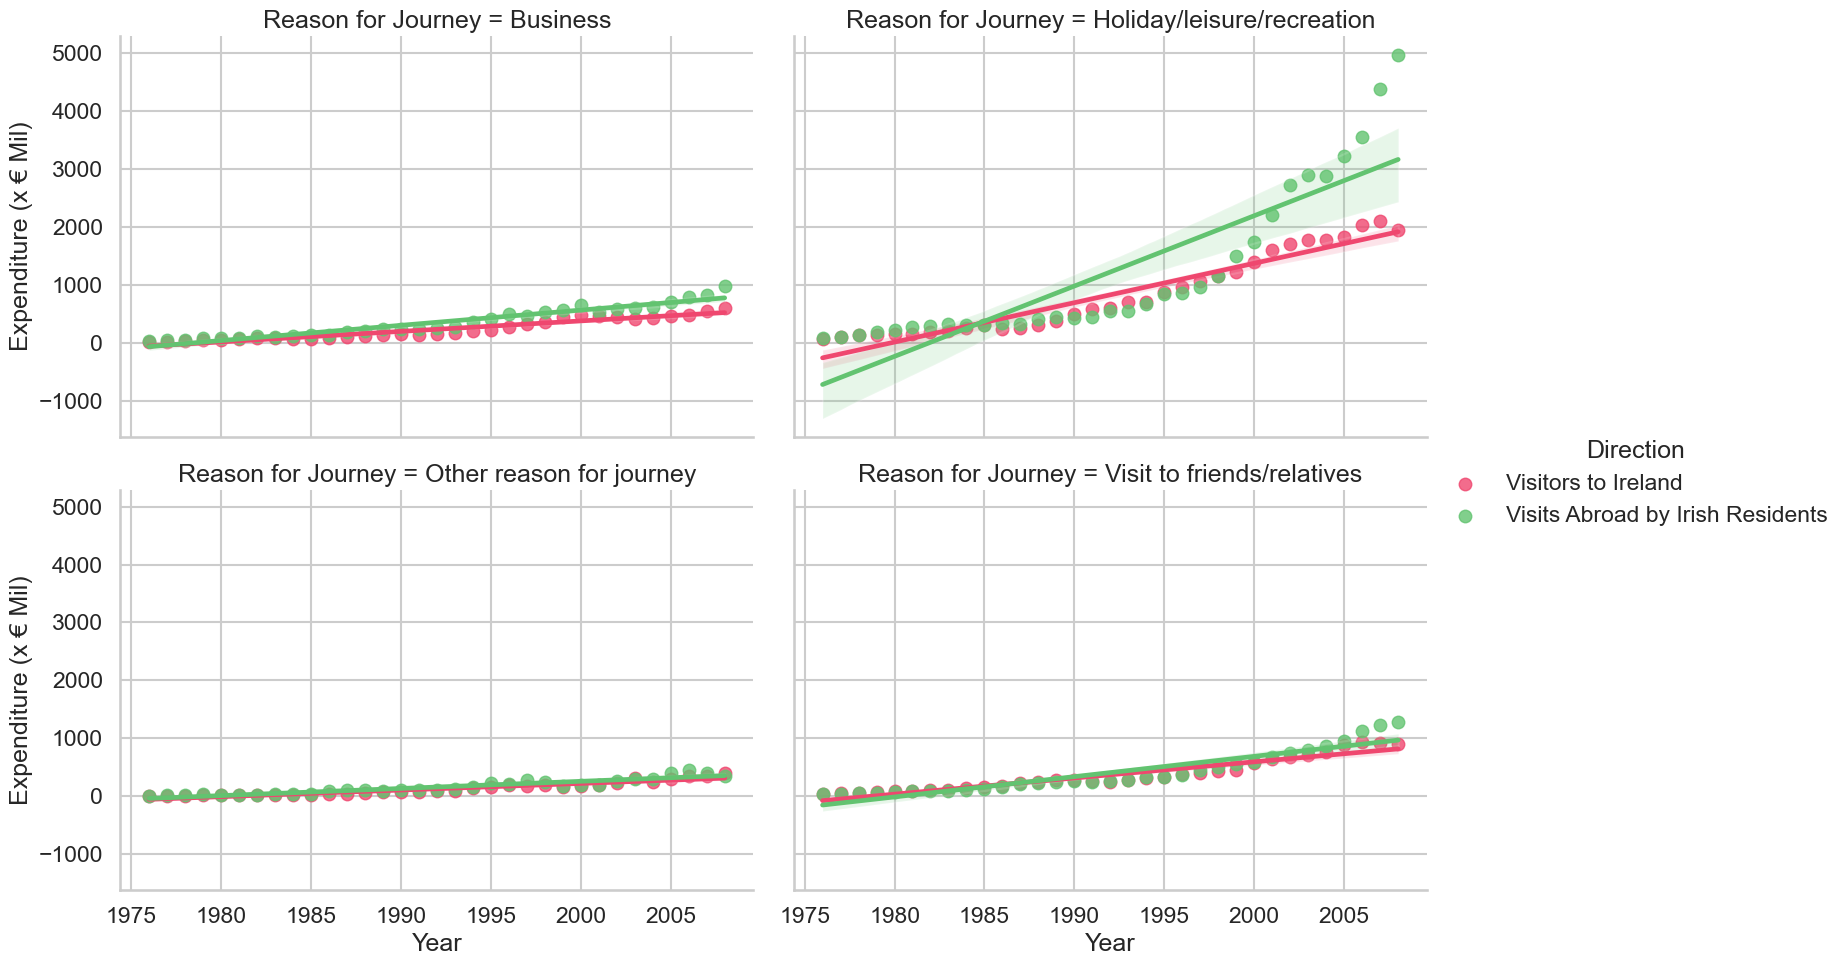

In [55]:
# Assess the annual trend of the Expenditure over the years by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Year", y="Expenditure (x € Mil)",
    height=5, hue='Direction', col='Reason for Journey', col_wrap=2, aspect=1.5
)

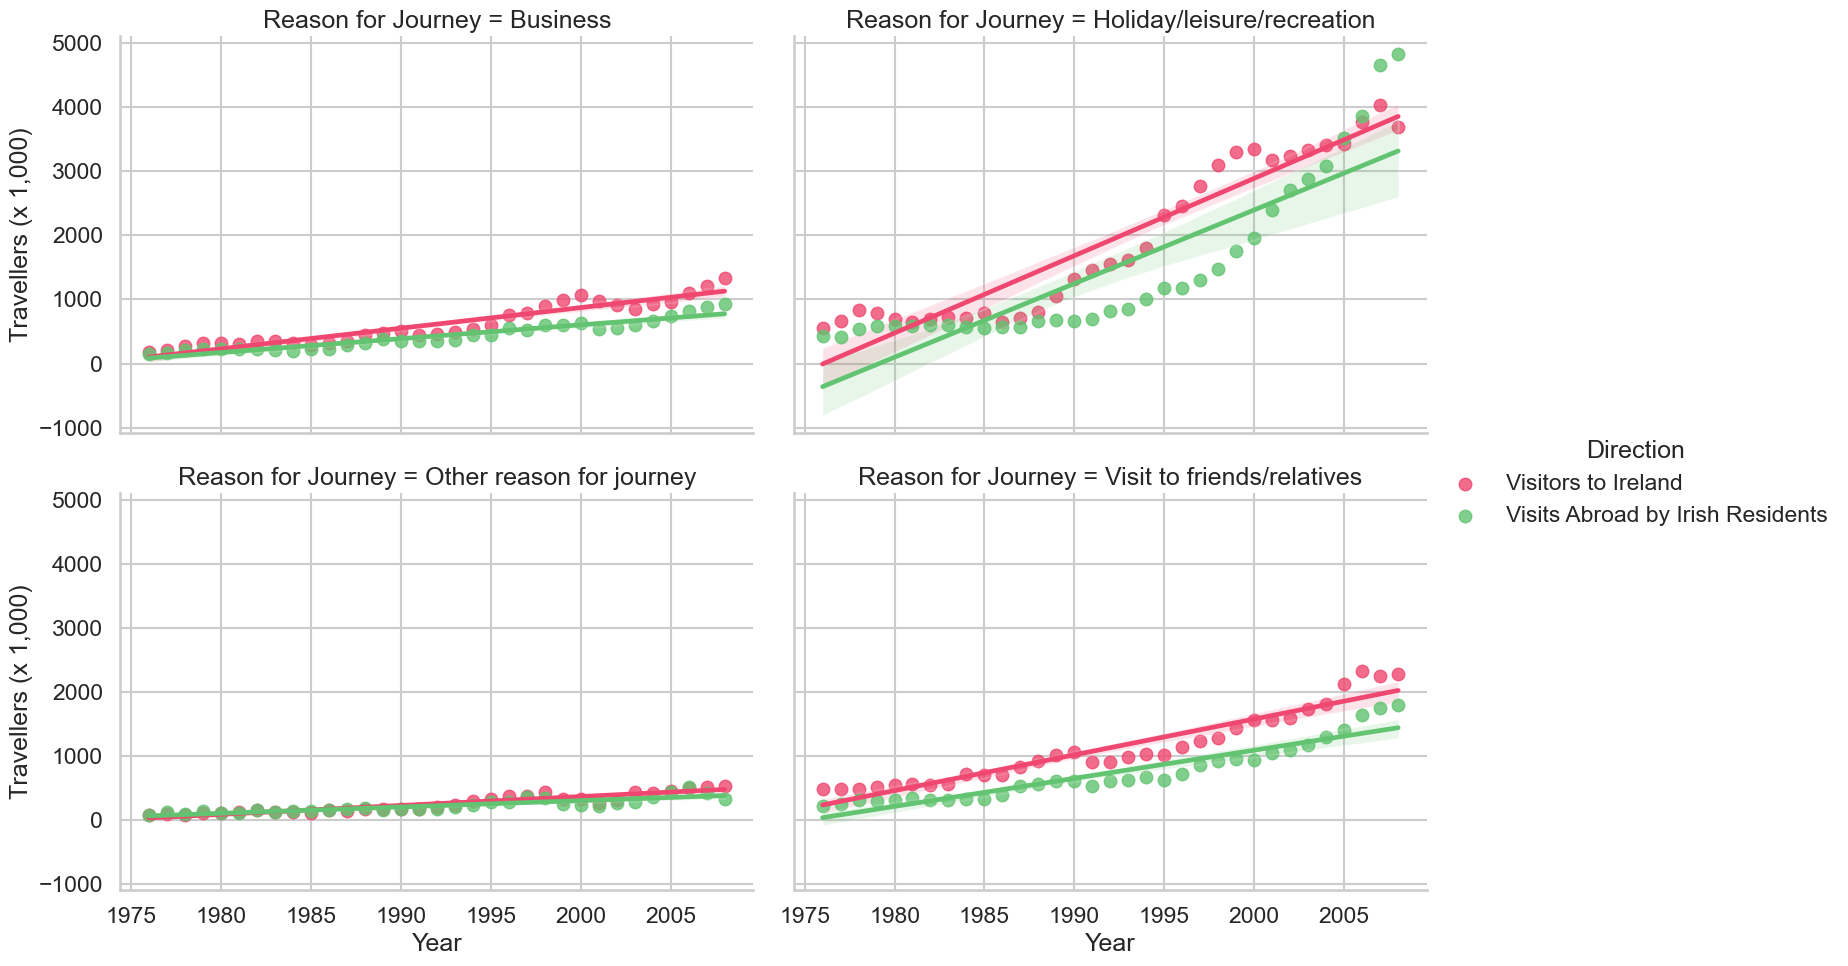

In [56]:
# Assess the annual trend of the number of travellers to and from Ireland over the years by reason for journey

g = sns.lmplot(
    data=final_df,
    x="Year", y="Travellers (x 1,000)",
    height=5, hue="Direction", col="Reason for Journey", col_wrap=2, aspect=1.5
)


In [57]:
# # Demonstrate relationship between # of travellers per year and expenditure per year

# g = sns.lmplot(
#     data=final_df,
#     x="Avg Length of Stay (x Nights)", y="Travellers (x 1,000)", hue="Direction", col= "Reason for Journey", col_wrap=2, aspect=1.5,
#     height=5
# )

# # Use more informative axis labels than are provided by default
# g.set_axis_labels("Avg Length of Stay (x Nights)", "Travellers (x 1,000)")

In [58]:
# # Demonstrate relationship between # of travellers per year and expenditure per year

# import seaborn as sns

# # Plot Expenditure as a function of # of travellers
# g = sns.lmplot(
#     data=final_df,
#     x="Expenditure (x € Mil)", y="Travellers (x 1,000)",
#     height=5
# )

# # Use more informative axis labels than are provided by default
# g.set_axis_labels("Travellers (x 1,000)", "Expenditure (x € Mil)");

In [59]:
# # Demonstrate relationship between # of travellers per year and expenditure per year

# import seaborn as sns

# # Plot Expenditure as a function of # of travellers
# g = sns.lmplot(
#     data=final_df,
#     x="Expenditure (x € Mil)", y="Travellers (x 1,000)",
#     height=5
# )

# # Use more informative axis labels than are provided by default
# g.set_axis_labels("Travellers (x 1,000)", "Expenditure (x € Mil)")

In [60]:

# TODO: Visualize data and see disttibution by reasons
# TODO: Statistics on data (probability of person being on buziness travel if...)
# TODO: ML Classification -> Random Forest, Decision Tree, etc - prediction for reason for travel

In [61]:
from sklearn.impute import KNNImputer

# Create an instance of KNNImputer
imputer = KNNImputer(n_neighbors=5)

# Impute missing values in final_df

In [62]:
from sklearn.preprocessing import LabelEncoder
from sklearn.impute import KNNImputer
# Encode categorical variables in final_df
label_encoder = LabelEncoder()
final_df_encoded = final_df.copy()
final_df_encoded['Direction'] = label_encoder.fit_transform(final_df_encoded['Direction'])
final_df_encoded['Reason for Journey'] = label_encoder.fit_transform(final_df_encoded['Reason for Journey'])

# Create an instance of KNNImputer
imp = KNNImputer(n_neighbors=5)

# Perform the imputation on final_df_encoded
final_df_imputed = imp.transform(final_df_encoded)


NotFittedError: This KNNImputer instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

In [ ]:
# Just pass in the colum - it imputes with mean value
one_col_impute = pd.DataFrame(imputer.fit_transform(final_df[['Avg Length of Stay (x Nights)']]))
one_col_impute.head(10)

,0
0,9.217308
1,9.217308
2,9.217308
3,9.217308
4,9.217308
5,9.217308
6,9.217308
7,9.217308
8,9.217308
9,9.217308


In [ ]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()

encoded = enc.fit_transform(final_df[['Direction', 'Reason for Journey']])
encoded_df = pd.DataFrame(encoded, columns=['Direction', 'Reason for Journey'])
encoded_df.head()

final_df_encoded = final_df.copy()
final_df_encoded['Direction'] = encoded_df['Direction']
final_df_encoded['Reason for Journey'] = encoded_df['Reason for Journey']

final_df_encoded.head()

,Direction,Reason for Journey
0,0.0,0.0
1,0.0,1.0
2,0.0,2.0
3,0.0,3.0
4,1.0,0.0


,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
0,1976,0.0,0.0,188.0,15.0,NaN
1,1976,0.0,1.0,553.0,69.0,NaN
2,1976,0.0,2.0,75.0,4.0,NaN
3,1976,0.0,3.0,494.0,43.0,NaN
4,1976,1.0,0.0,150.0,33.0,NaN


In [ ]:
final_df_imputed = pd.DataFrame(imputer.fit_transform(final_df_encoded), columns=['Year', 'Direction', 'Reason for Journey', 'Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)'])
final_df_imputed.loc[(final_df_imputed['Reason for Journey']==1.0)].head(20)

,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
1,1976.0,0.0,1.0,553.0,69.0,5.66
5,1976.0,1.0,1.0,428.0,81.0,4.04
9,1977.0,0.0,1.0,665.0,98.0,11.26
13,1977.0,1.0,1.0,420.0,94.0,5.48
17,1978.0,0.0,1.0,838.0,132.0,10.72
21,1978.0,1.0,1.0,540.0,136.0,5.66
25,1979.0,0.0,1.0,790.0,140.0,11.16
29,1979.0,1.0,1.0,588.0,185.0,8.28
33,1980.0,0.0,1.0,703.0,142.0,11.26
37,1980.0,1.0,1.0,583.0,223.0,8.04


In [ ]:
# I tried to drop the columns for Travellers and Expenditure to see how imputed values changed, but it did not work, perhaps because the use of ordinal encoding for the categorical variables instead onehot encoding, thereby attributing a relational value to the categorical variables, which may have affected the imputation process. I will try again with onehot
imputed_cols_dropped = pd.DataFrame(imputer.fit_transform(final_df_encoded.drop(columns=['Travellers (x 1,000)', 'Expenditure (x € Mil)'])), columns=['Year', 'Direction', 'Reason for Journey', 'Avg Length of Stay (x Nights)'])
imputed_cols_dropped.loc[(final_df_imputed['Reason for Journey']==1.0)].head(20)

,Year,Direction,Reason for Journey,Avg Length of Stay (x Nights)
1,1976.0,0.0,1.0,7.52
5,1976.0,1.0,1.0,7.48
9,1977.0,0.0,1.0,7.52
13,1977.0,1.0,1.0,7.48
17,1978.0,0.0,1.0,7.52
21,1978.0,1.0,1.0,7.48
25,1979.0,0.0,1.0,7.52
29,1979.0,1.0,1.0,7.48
33,1980.0,0.0,1.0,7.52
37,1980.0,1.0,1.0,7.48


In [ ]:
# Try onehot encoding to see if it will work better
OneHot_final_df = pd.get_dummies(final_df)
OneHot_final_df.head(20)

,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976,188.0,15.0,NaN,True,False,True,False,False,False
1,1976,553.0,69.0,NaN,True,False,False,True,False,False
2,1976,75.0,4.0,NaN,True,False,False,False,True,False
3,1976,494.0,43.0,NaN,True,False,False,False,False,True
4,1976,150.0,33.0,NaN,False,True,True,False,False,False
5,1976,428.0,81.0,NaN,False,True,False,True,False,False
6,1976,87.0,10.0,NaN,False,True,False,False,True,False
7,1976,222.0,32.0,NaN,False,True,False,False,False,True
8,1977,214.0,20.0,NaN,True,False,True,False,False,False
9,1977,665.0,98.0,NaN,True,False,False,True,False,False


### I think this is the best imputation as it reflects the recurring trends seen in the existing data between reasons for journey

In [ ]:
# By using One-hot encoding of the categorical variables (Direction & Reason for Journey), I avoid imposing an erroneous hierarchy or order to the Categorical Variables allowing 
# the imputation process to fill in the missing values for the numerical variables in Average LEnght of stay for the years from 1976 to 2008.
OneHot_final_df_dropped = pd.DataFrame(imputer.fit_transform(OneHot_final_df.drop(columns=['Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Year'])))

OneHot_final_df_dropped.head(20)

,0,1,2,3,4,5,6
0,4.90,1.0,0.0,1.0,0.0,0.0,0.0
1,9.92,1.0,0.0,0.0,1.0,0.0,0.0
2,13.12,1.0,0.0,0.0,0.0,1.0,0.0
3,9.90,1.0,0.0,0.0,0.0,0.0,1.0
4,6.30,0.0,1.0,1.0,0.0,0.0,0.0
5,10.54,0.0,1.0,0.0,1.0,0.0,0.0
6,13.72,0.0,1.0,0.0,0.0,1.0,0.0
7,9.88,0.0,1.0,0.0,0.0,0.0,1.0
8,4.90,1.0,0.0,1.0,0.0,0.0,0.0
9,9.92,1.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
OneHot_final_df_dropped.describe()

,0,1,2,3,4,5,6
count,264.000000,264.00000,264.00000,264.000000,264.000000,264.000000,264.000000
mean,9.337727,0.50000,0.50000,0.250000,0.250000,0.250000,0.250000
std,3.043871,0.50095,0.50095,0.433835,0.433835,0.433835,0.433835
min,3.400000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
25%,6.900000,0.00000,0.00000,0.000000,0.000000,0.000000,0.000000
50%,9.880000,0.50000,0.50000,0.000000,0.000000,0.000000,0.000000
75%,11.000000,1.00000,1.00000,0.250000,0.250000,0.250000,0.250000
max,23.000000,1.00000,1.00000,1.000000,1.000000,1.000000,1.000000


In [ ]:
# Impute missing values using OneHot_final_df
#OneHot_final_df_imputed = pd.DataFrame(imputer.transform(OneHot_final_df[['Year', 'Travellers (x 1,000)', 'Expenditure (x € Mil)', 'Avg Length of Stay (x Nights)', 'Direction_Visitors to Ireland', 'Direction_Visits Abroad by Irish Residents', 'Reason for Journey_Business', 'Reason for Journey_Holiday/leisure/recreation', 'Reason for Journey_Other reason for journey', 'Reason for Journey_Visit to friends/relatives']]))
OneHot_final_df_imputed = pd.DataFrame(imputer.fit_transform(OneHot_final_df))

# Assign the imputed values to the original DataFrame
#OneHot_final_df[['Avg Length of Stay (x Nights)']] = OneHot_final_df_imputed

# # Print the updated DataFrame
# OneHot_final_df_imputed
# OneHot_final_df


,0,1,2,3,4,5,6,7,8,9
0,1976.0,188.0,15.0,8.82,1.0,0.0,1.0,0.0,0.0,0.0
1,1976.0,553.0,69.0,5.66,1.0,0.0,0.0,1.0,0.0,0.0
2,1976.0,75.0,4.0,5.94,1.0,0.0,0.0,0.0,1.0,0.0
3,1976.0,494.0,43.0,5.48,1.0,0.0,0.0,0.0,0.0,1.0
4,1976.0,150.0,33.0,8.16,0.0,1.0,1.0,0.0,0.0,0.0
5,1976.0,428.0,81.0,4.04,0.0,1.0,0.0,1.0,0.0,0.0
6,1976.0,87.0,10.0,5.94,0.0,1.0,0.0,0.0,1.0,0.0
7,1976.0,222.0,32.0,11.60,0.0,1.0,0.0,0.0,0.0,1.0
8,1977.0,214.0,20.0,11.26,1.0,0.0,1.0,0.0,0.0,0.0
9,1977.0,665.0,98.0,11.26,1.0,0.0,0.0,1.0,0.0,0.0


,Year,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights),Direction_Visitors to Ireland,Direction_Visits Abroad by Irish Residents,Reason for Journey_Business,Reason for Journey_Holiday/leisure/recreation,Reason for Journey_Other reason for journey,Reason for Journey_Visit to friends/relatives
0,1976,188.0,15.0,NaN,True,False,True,False,False,False
1,1976,553.0,69.0,NaN,True,False,False,True,False,False
2,1976,75.0,4.0,NaN,True,False,False,False,True,False
3,1976,494.0,43.0,NaN,True,False,False,False,False,True
4,1976,150.0,33.0,NaN,False,True,True,False,False,False
5,1976,428.0,81.0,NaN,False,True,False,True,False,False
6,1976,87.0,10.0,NaN,False,True,False,False,True,False
7,1976,222.0,32.0,NaN,False,True,False,False,False,True
8,1977,214.0,20.0,NaN,True,False,True,False,False,False
9,1977,665.0,98.0,NaN,True,False,False,True,False,False


In [ ]:
# Just pass in the colum - it imputes with mean value
OneHot_final_df = pd.DataFrame(imputer.fit_transform(OneHot_final_df[['Avg Length of Stay (x Nights)']]))
OneHot_final_df.head(10)

,0
0,9.217308
1,9.217308
2,9.217308
3,9.217308
4,9.217308
5,9.217308
6,9.217308
7,9.217308
8,9.217308
9,9.217308


In [ ]:
final_df.loc[(final_df['Reason for Journey']=='Holiday/leisure/recreation')]

,Year,Direction,Reason for Journey,"Travellers (x 1,000)",Expenditure (x € Mil),Avg Length of Stay (x Nights)
1,1976,Visitors to Ireland,Holiday/leisure/recreation,553.0,69.0,NaN
5,1976,Visits Abroad by Irish Residents,Holiday/leisure/recreation,428.0,81.0,NaN
9,1977,Visitors to Ireland,Holiday/leisure/recreation,665.0,98.0,NaN
13,1977,Visits Abroad by Irish Residents,Holiday/leisure/recreation,420.0,94.0,NaN
17,1978,Visitors to Ireland,Holiday/leisure/recreation,838.0,132.0,NaN
21,1978,Visits Abroad by Irish Residents,Holiday/leisure/recreation,540.0,136.0,NaN
25,1979,Visitors to Ireland,Holiday/leisure/recreation,790.0,140.0,NaN
29,1979,Visits Abroad by Irish Residents,Holiday/leisure/recreation,588.0,185.0,NaN
33,1980,Visitors to Ireland,Holiday/leisure/recreation,703.0,142.0,NaN
37,1980,Visits Abroad by Irish Residents,Holiday/leisure/recreation,583.0,223.0,NaN


In [ ]:
# TODO: try a regression imputer https://datasciencestunt.com/regression-imputation/